This file contains the work to generate core users and feeding it to IDCF codebase for ML-100k dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [1]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

- code to read and clean douban book review file.

In [23]:
ml1m_dir = 'data/bookreviews_cleaned.txt'
# ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True,index_col=0, engine='python')
ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, usecols=range(3), header=None)
# df = ml1m_rating[["user_id", book_id", "rating", "time"]]
ml1m_rating.head()
ml1m_rating.to_csv('data/douban_bookreview.csv', index=False)


In [28]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/douban_bookreview.csv'
    ml1m_rating = pd.read_csv(ml1m_dir, sep=',', header=None, names=['uid', 'mid', 'rating'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [30]:
THRESHOLD = 20 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
          uid    mid  ratings
0        613  55945        3
1        613  81196        4
2        613  32933        4
3        613  62950        5
4        613  59289        4
...      ...    ...      ...
227246  1814   4305        5
227247  1814   5877        5
227248  1814    809        5
227249  1814   1022        4
227250  1814   1051        5

[220555 rows x 3 columns]
LESS THAN 30: 
          uid    mid  ratings
285     1707  53320        1
286     1707  60332        5
287     1707  56218        5
288     1707  56068        4
289     1707  51775        4
...      ...    ...      ...
226701  1960  64798        5
226702  1960  37438        4
226703  1960  36476        4
226704  1960  69785        4
226705  1960   5762        4

[6696 rows x 3 columns]
GREATER THAN THRESHOLD:  220555
LESS THAN THRESHOLD:  6696
UNIQUE MIDS:  95872
UNIQUE UIDS:  2212


In [31]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 1371
NUMBER OF USERS IN SUPPORT TRAIN 1371
NUMBER OF USERS IN QUERY TEST: 841
NUMBER OF USERS IN QUERY TRAIN 725


In [32]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [33]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [34]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [35]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [36]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 1371
MOVIE LEN: 95872
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
SHAPE OF COSINE MATIX:
  (1371, 1371)
CORE USERS:         uid    mid  ratings
0       262  55945        3
1       262  81196        4
2       262  32933        4
3       262  62950        5
4       262  59289        4
...     ...    ...      ...
226836  359  32270        4
226837  359  85114        5
226838  359  44411        3
226839  359  83714        5
226840  359   6924        5

[46357 rows x 3 columns]
NUMBER OF CORE USERS: 274


In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [37]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:         uid    mid  ratings
0       262  55945        3
1       262  81196        4
2       262  32933        4
3       262  62950        5
4       262  59289        4
...     ...    ...      ...
226836  359  32270        4
226837  359  85114        5
226838  359  44411        3
226839  359  83714        5
226840  359   6924        5

[46357 rows x 3 columns]


In [38]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

274
SUPPORT TEST DF:          uid    mid  ratings
284      613   6169        4
377     2024  83209        1
8073    1920  72451        3
9197     306   2331        5
9499    1447   1785        5
...      ...    ...      ...
225378  1965  31437        5
225529  1701   9819        2
226241  1740  72519        5
226689  1348   6066        5
226841   837  43146        1

[274 rows x 3 columns]
QUERY TEST DF:
          uid    mid  ratings
295     1707  87421        5
299     1620  18452        4
302     1889  74757        4
307      447  75026        4
346       70  69124        5
...      ...    ...      ...
225124   782  24626        5
225541   658  74333        5
226250  1958  29817        3
226261  1170  69547        4
226705  1960   5762        4

[841 rows x 3 columns]


In [39]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [40]:
import pickle
with open("douban_cos_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% douban cos coreusers into IDCF

In [43]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 46357/5855
test set size: support/query 274/841
Epoch 0 Step 44: Train 12.2825 Reg: 0.6802
Test: 7.6953 MAE: 2.6438 RMSE: 2.7740
Val: 5.5627 MAE: 2.1928 RMSE: 2.3585
Epoch 1 Step 88: Train 1.7782 Reg: 0.5602
Test: 0.8560 MAE: 0.7845 RMSE: 0.9252
Val: 0.8442 MAE: 0.6933 RMSE: 0.9188
Epoch 2 Step 132: Train 0.7528 Reg: 0.4985
Test: 0.8982 MAE: 0.8125 RMSE: 0.9477
Val: 0.7947 MAE: 0.6991 RMSE: 0.8915
Epoch 3 Step 176: Train 0.6989 Reg: 0.4343
Test: 0.8767 MAE: 0.7969 RMSE: 0.9363
Val: 0.7618 MAE: 0.6828 RMSE: 0.8728
Epoch 4 Step 220: Train 0.6519 Reg: 0.4576
Test: 0.8768 MAE: 0.7856 RMSE: 0.9364
Val: 0.7437 MAE: 0.6768 RMSE: 0.8624
Epoch 5 Step 264: Train 0.6098 Reg: 0.5074
Test: 0.8629 MAE: 0.7741 RMSE: 0.9289
Val: 0.7340 MAE: 0.6758 RMSE: 0.8567
Epoch 6 Step 308: Train 0.5686 Reg: 0.5686
Test: 0.8493 MAE: 0.7583 RMSE: 0.9215
Val: 0.7329 MAE: 0.6770 RMSE: 0.8561
Epoch 7 St

- 20% douban cos coueusers to IDCF

In [44]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 46357/5855
test set size: support/query 274/841
Epoch 0 Step 44: Train 11.9656 Reg: 0.6761
Test: 7.2786 MAE: 2.5661 RMSE: 2.6979
Val: 5.2677 MAE: 2.1348 RMSE: 2.2952
Epoch 1 Step 88: Train 1.6395 Reg: 0.5614
Test: 0.8084 MAE: 0.7567 RMSE: 0.8991
Val: 0.7807 MAE: 0.6783 RMSE: 0.8836
Epoch 2 Step 132: Train 0.7402 Reg: 0.5193
Test: 0.8985 MAE: 0.8114 RMSE: 0.9479
Val: 0.7172 MAE: 0.6794 RMSE: 0.8468
Epoch 3 Step 176: Train 0.6737 Reg: 0.4771
Test: 0.8651 MAE: 0.7852 RMSE: 0.9301
Val: 0.6839 MAE: 0.6604 RMSE: 0.8270
Epoch 4 Step 220: Train 0.6227 Reg: 0.5141
Test: 0.8630 MAE: 0.7752 RMSE: 0.9290
Val: 0.6689 MAE: 0.6551 RMSE: 0.8179
Epoch 5 Step 264: Train 0.5761 Reg: 0.5762
Test: 0.8428 MAE: 0.7567 RMSE: 0.9180
Val: 0.6663 MAE: 0.6542 RMSE: 0.8163
Epoch 6 Step 308: Train 0.5321 Reg: 0.6419
Test: 0.8316 MAE: 0.7484 RMSE: 0.9119
Val: 0.6705 MAE: 0.6545 RMSE: 0.8188
Epoch 7 St

- 40% douban cos core user as input to IDCF

In [45]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 92063/5855
test set size: support/query 548/841
Epoch 0 Step 86: Train 7.2229 Reg: 0.6657
Test: 0.9189 MAE: 0.8026 RMSE: 0.9586
Val: 0.8435 MAE: 0.6953 RMSE: 0.9184
Epoch 1 Step 172: Train 0.7773 Reg: 0.5546
Test: 0.9195 MAE: 0.8105 RMSE: 0.9589
Val: 0.7594 MAE: 0.6794 RMSE: 0.8715
Epoch 2 Step 258: Train 0.7084 Reg: 0.5705
Test: 0.8655 MAE: 0.7754 RMSE: 0.9303
Val: 0.7328 MAE: 0.6761 RMSE: 0.8560
Epoch 3 Step 344: Train 0.6666 Reg: 0.6927
Test: 0.8387 MAE: 0.7570 RMSE: 0.9158
Val: 0.7202 MAE: 0.6716 RMSE: 0.8487
Epoch 4 Step 430: Train 0.6312 Reg: 0.8148
Test: 0.8015 MAE: 0.7391 RMSE: 0.8953
Val: 0.7112 MAE: 0.6662 RMSE: 0.8433
Epoch 5 Step 516: Train 0.5963 Reg: 0.9169
Test: 0.8054 MAE: 0.7354 RMSE: 0.8974
Val: 0.7061 MAE: 0.6628 RMSE: 0.8403
Epoch 6 Step 602: Train 0.5600 Reg: 1.0043
Test: 0.8000 MAE: 0.7218 RMSE: 0.8944
Val: 0.7191 MAE: 0.6656 RMSE: 0.8480
Epoch 7 St

- 60% souban cos coreusers input to IDCF

In [46]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 131477/5855
test set size: support/query 822/841
Epoch 0 Step 122: Train 5.3803 Reg: 0.7330
Test: 1.0197 MAE: 0.8565 RMSE: 1.0098
Val: 0.7801 MAE: 0.6891 RMSE: 0.8832
Epoch 1 Step 244: Train 0.7439 Reg: 0.6692
Test: 0.9197 MAE: 0.7987 RMSE: 0.9590
Val: 0.7185 MAE: 0.6712 RMSE: 0.8476
Epoch 2 Step 366: Train 0.6923 Reg: 0.8223
Test: 0.8809 MAE: 0.7747 RMSE: 0.9385
Val: 0.7075 MAE: 0.6675 RMSE: 0.8411
Epoch 3 Step 488: Train 0.6609 Reg: 0.9764
Test: 0.8486 MAE: 0.7561 RMSE: 0.9212
Val: 0.7013 MAE: 0.6628 RMSE: 0.8374
Epoch 4 Step 610: Train 0.6335 Reg: 1.0855
Test: 0.8615 MAE: 0.7606 RMSE: 0.9282
Val: 0.6973 MAE: 0.6608 RMSE: 0.8350
Epoch 5 Step 732: Train 0.6081 Reg: 1.1619
Test: 0.8572 MAE: 0.7569 RMSE: 0.9258
Val: 0.6982 MAE: 0.6614 RMSE: 0.8356
Epoch 6 Step 854: Train 0.5824 Reg: 1.2139
Test: 0.8683 MAE: 0.7572 RMSE: 0.9318
Val: 0.7069 MAE: 0.6640 RMSE: 0.8408
Epoch 7 

- 80% douban cos into IDCF

In [24]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 84997/4938
test set size: support/query 584/213
Epoch 0 Step 79: Train 6.6028 Reg: 0.4592
Test: 1.1456 MAE: 0.8695 RMSE: 1.0703
Val: 1.1703 MAE: 0.8688 RMSE: 1.0818
Epoch 1 Step 158: Train 1.0108 Reg: 0.4572
Test: 0.9544 MAE: 0.7821 RMSE: 0.9769
Val: 0.9422 MAE: 0.7755 RMSE: 0.9707
Epoch 2 Step 237: Train 0.8862 Reg: 0.4287
Test: 0.9027 MAE: 0.7476 RMSE: 0.9501
Val: 0.8970 MAE: 0.7449 RMSE: 0.9471
Epoch 3 Step 316: Train 0.8556 Reg: 0.4094
Test: 0.8874 MAE: 0.7436 RMSE: 0.9420
Val: 0.8798 MAE: 0.7384 RMSE: 0.9380
Epoch 4 Step 395: Train 0.8451 Reg: 0.3925
Test: 0.8758 MAE: 0.7390 RMSE: 0.9359
Val: 0.8752 MAE: 0.7361 RMSE: 0.9355
Epoch 5 Step 474: Train 0.8399 Reg: 0.3775
Test: 0.8745 MAE: 0.7379 RMSE: 0.9352
Val: 0.8731 MAE: 0.7347 RMSE: 0.9344
Epoch 6 Step 553: Train 0.8369 Reg: 0.3643
Test: 0.8760 MAE: 0.7383 RMSE: 0.9360
Val: 0.8677 MAE: 0.7334 RMSE: 0.9315
Epoch 7 St

- 100% douban cos to IDCF

In [1]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 219184/5855
test set size: support/query 1371/841
Epoch 0 Step 204: Train 3.6691 Reg: 0.8305
Test: 0.9901 MAE: 0.8344 RMSE: 0.9950
Val: 0.7732 MAE: 0.6878 RMSE: 0.8793
Epoch 1 Step 408: Train 0.7481 Reg: 1.0331
Test: 0.9388 MAE: 0.8000 RMSE: 0.9689
Val: 0.7450 MAE: 0.6828 RMSE: 0.8631
Epoch 2 Step 612: Train 0.7135 Reg: 1.2992
Test: 0.9268 MAE: 0.7890 RMSE: 0.9627
Val: 0.7322 MAE: 0.6758 RMSE: 0.8557
Epoch 3 Step 816: Train 0.6938 Reg: 1.3750
Test: 0.8938 MAE: 0.7743 RMSE: 0.9454
Val: 0.7256 MAE: 0.6727 RMSE: 0.8518
Epoch 4 Step 1020: Train 0.6778 Reg: 1.3820
Test: 0.8891 MAE: 0.7714 RMSE: 0.9429
Val: 0.7276 MAE: 0.6737 RMSE: 0.8530
Epoch 5 Step 1224: Train 0.6634 Reg: 1.3732
Test: 0.8892 MAE: 0.7670 RMSE: 0.9430
Val: 0.7244 MAE: 0.6721 RMSE: 0.8511
Epoch 6 Step 1428: Train 0.6489 Reg: 1.3632
Test: 0.8780 MAE: 0.7603 RMSE: 0.9370
Val: 0.7244 MAE: 0.6722 RMSE: 0.8511
Epoc

- 10% douban cur input to IDCF

In [2]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 56961/5855
test set size: support/query 137/841
Epoch 0 Step 53: Train 11.2858 Reg: 0.6153
Test: 4.3148 MAE: 1.9023 RMSE: 2.0772
Val: 3.0434 MAE: 1.5531 RMSE: 1.7445
Epoch 1 Step 106: Train 1.1360 Reg: 0.5069
Test: 1.1366 MAE: 0.8954 RMSE: 1.0661
Val: 0.8672 MAE: 0.7057 RMSE: 0.9313
Epoch 2 Step 159: Train 0.8076 Reg: 0.3186
Test: 1.1254 MAE: 0.9072 RMSE: 1.0608
Val: 0.8340 MAE: 0.7145 RMSE: 0.9133
Epoch 3 Step 212: Train 0.7667 Reg: 0.3402
Test: 1.0708 MAE: 0.8803 RMSE: 1.0348
Val: 0.8195 MAE: 0.7068 RMSE: 0.9052
Epoch 4 Step 265: Train 0.7228 Reg: 0.4533
Test: 1.0403 MAE: 0.8687 RMSE: 1.0199
Val: 0.8145 MAE: 0.7071 RMSE: 0.9025
Epoch 5 Step 318: Train 0.6653 Reg: 0.6160
Test: 1.0205 MAE: 0.8601 RMSE: 1.0102
Val: 0.8115 MAE: 0.7113 RMSE: 0.9008
Epoch 6 Step 371: Train 0.5867 Reg: 0.7986
Test: 1.0056 MAE: 0.8542 RMSE: 1.0028
Val: 0.8140 MAE: 0.7148 RMSE: 0.9022
Epoch 7 S

- 20% douban cur as input to IDCF

In [3]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 101492/5855
test set size: support/query 274/841
Epoch 0 Step 95: Train 6.5241 Reg: 0.6429
Test: 1.0427 MAE: 0.8238 RMSE: 1.0211
Val: 0.8088 MAE: 0.6779 RMSE: 0.8994
Epoch 1 Step 190: Train 0.7689 Reg: 0.4590
Test: 1.0306 MAE: 0.8435 RMSE: 1.0152
Val: 0.7396 MAE: 0.6727 RMSE: 0.8600
Epoch 2 Step 285: Train 0.7162 Reg: 0.6024
Test: 1.0083 MAE: 0.8301 RMSE: 1.0041
Val: 0.7237 MAE: 0.6719 RMSE: 0.8507
Epoch 3 Step 380: Train 0.6733 Reg: 0.8455
Test: 0.9884 MAE: 0.8231 RMSE: 0.9942
Val: 0.7186 MAE: 0.6705 RMSE: 0.8477
Epoch 4 Step 475: Train 0.6236 Reg: 1.0735
Test: 1.0125 MAE: 0.8242 RMSE: 1.0062
Val: 0.7195 MAE: 0.6691 RMSE: 0.8483
Epoch 5 Step 570: Train 0.5659 Reg: 1.2586
Test: 1.0673 MAE: 0.8477 RMSE: 1.0331
Val: 0.7289 MAE: 0.6760 RMSE: 0.8538
Epoch 6 Step 665: Train 0.5121 Reg: 1.3716
Test: 0.9957 MAE: 0.8070 RMSE: 0.9979
Val: 0.7404 MAE: 0.6750 RMSE: 0.8605
Epoch 7 S

- 40%  douban cur coreuser as input to IDCF

In [4]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 151867/5855
test set size: support/query 548/841
Epoch 0 Step 141: Train 4.7336 Reg: 0.6500
Test: 1.0856 MAE: 0.8772 RMSE: 1.0419
Val: 0.7890 MAE: 0.6903 RMSE: 0.8882
Epoch 1 Step 282: Train 0.7529 Reg: 0.6608
Test: 0.9988 MAE: 0.8265 RMSE: 0.9994
Val: 0.7383 MAE: 0.6753 RMSE: 0.8592
Epoch 2 Step 423: Train 0.7108 Reg: 0.9555
Test: 0.9664 MAE: 0.8059 RMSE: 0.9831
Val: 0.7291 MAE: 0.6703 RMSE: 0.8539
Epoch 3 Step 564: Train 0.6785 Reg: 1.1878
Test: 0.9634 MAE: 0.7974 RMSE: 0.9815
Val: 0.7301 MAE: 0.6704 RMSE: 0.8545
Epoch 4 Step 705: Train 0.6492 Reg: 1.3343
Test: 0.9586 MAE: 0.7933 RMSE: 0.9791
Val: 0.7232 MAE: 0.6692 RMSE: 0.8504
Epoch 5 Step 846: Train 0.6192 Reg: 1.4387
Test: 0.9869 MAE: 0.8059 RMSE: 0.9934
Val: 0.7320 MAE: 0.6737 RMSE: 0.8556
Epoch 6 Step 987: Train 0.5862 Reg: 1.5174
Test: 0.9903 MAE: 0.7919 RMSE: 0.9951
Val: 0.7393 MAE: 0.6741 RMSE: 0.8598
Epoch 7 

- 60% cos coreuser as input to IDCF

In [5]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 184249/5855
test set size: support/query 822/841
Epoch 0 Step 171: Train 4.0633 Reg: 0.7204
Test: 1.0359 MAE: 0.8604 RMSE: 1.0178
Val: 0.7962 MAE: 0.6941 RMSE: 0.8923
Epoch 1 Step 342: Train 0.7458 Reg: 0.8549
Test: 0.9757 MAE: 0.8171 RMSE: 0.9878
Val: 0.7646 MAE: 0.6874 RMSE: 0.8744
Epoch 2 Step 513: Train 0.7076 Reg: 1.1444
Test: 0.9532 MAE: 0.8083 RMSE: 0.9763
Val: 0.7557 MAE: 0.6843 RMSE: 0.8693
Epoch 3 Step 684: Train 0.6829 Reg: 1.3017
Test: 0.9419 MAE: 0.8030 RMSE: 0.9705
Val: 0.7551 MAE: 0.6828 RMSE: 0.8689
Epoch 4 Step 855: Train 0.6619 Reg: 1.3871
Test: 0.9646 MAE: 0.8102 RMSE: 0.9822
Val: 0.7472 MAE: 0.6812 RMSE: 0.8644
Epoch 5 Step 1026: Train 0.6413 Reg: 1.4426
Test: 0.9673 MAE: 0.8052 RMSE: 0.9835
Val: 0.7548 MAE: 0.6850 RMSE: 0.8688
Epoch 6 Step 1197: Train 0.6191 Reg: 1.4802
Test: 0.9407 MAE: 0.7950 RMSE: 0.9699
Val: 0.7572 MAE: 0.6847 RMSE: 0.8702
Epoch 

- 80% douban cos coreuser input to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 207475/5855
test set size: support/query 1096/841
Epoch 0 Step 193: Train 3.9153 Reg: 0.7588
Test: 1.0206 MAE: 0.8464 RMSE: 1.0102
Val: 0.8041 MAE: 0.7033 RMSE: 0.8967
Epoch 1 Step 386: Train 0.7464 Reg: 0.9414
Test: 0.9465 MAE: 0.7990 RMSE: 0.9729
Val: 0.7695 MAE: 0.6946 RMSE: 0.8772
Epoch 2 Step 579: Train 0.7110 Reg: 1.2159
Test: 0.9332 MAE: 0.7899 RMSE: 0.9660
Val: 0.7602 MAE: 0.6892 RMSE: 0.8719
Epoch 3 Step 772: Train 0.6900 Reg: 1.3245
Test: 0.9186 MAE: 0.7838 RMSE: 0.9584
Val: 0.7532 MAE: 0.6873 RMSE: 0.8679
Epoch 4 Step 965: Train 0.6725 Reg: 1.3625
Test: 0.9048 MAE: 0.7735 RMSE: 0.9512
Val: 0.7515 MAE: 0.6872 RMSE: 0.8669
Epoch 5 Step 1158: Train 0.6560 Reg: 1.3706
Test: 0.9237 MAE: 0.7768 RMSE: 0.9611
Val: 0.7500 MAE: 0.6861 RMSE: 0.8660
Epoch 6 Step 1351: Train 0.6382 Reg: 1.3623
Test: 0.9307 MAE: 0.7831 RMSE: 0.9647
Val: 0.7495 MAE: 0.6856 RMSE: 0.8657
Epoch

- 100% support user as cos core user to IDCF

In [33]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 5.7745 Reg: 0.4774
Test: 1.1326 MAE: 0.8667 RMSE: 1.0642
Val: 1.1027 MAE: 0.8496 RMSE: 1.0501
Epoch 1 Step 176: Train 0.9613 Reg: 0.4771
Test: 0.9707 MAE: 0.7764 RMSE: 0.9852
Val: 0.9213 MAE: 0.7650 RMSE: 0.9599
Epoch 2 Step 264: Train 0.8752 Reg: 0.4516
Test: 0.9511 MAE: 0.7680 RMSE: 0.9753
Val: 0.8905 MAE: 0.7500 RMSE: 0.9436
Epoch 3 Step 352: Train 0.8573 Reg: 0.4304
Test: 0.9398 MAE: 0.7625 RMSE: 0.9695
Val: 0.8809 MAE: 0.7444 RMSE: 0.9385
Epoch 4 Step 440: Train 0.8505 Reg: 0.4110
Test: 0.9390 MAE: 0.7624 RMSE: 0.9690
Val: 0.8764 MAE: 0.7418 RMSE: 0.9362
Epoch 5 Step 528: Train 0.8464 Reg: 0.3934
Test: 0.9283 MAE: 0.7569 RMSE: 0.9635
Val: 0.8738 MAE: 0.7403 RMSE: 0.9348
Epoch 6 Step 616: Train 0.8440 Reg: 0.3785
Test: 0.9277 MAE: 0.7564 RMSE: 0.9632
Val: 0.8735 MAE: 0.7405 RMSE: 0.9346
Epoch 7 St

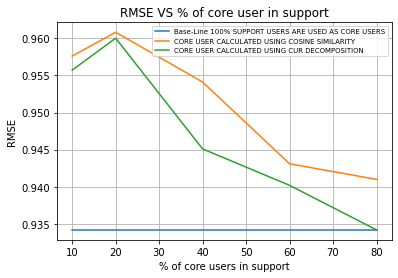

In [7]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60, 80]
y_axis = [0.9576, 0.9608, 0.9541, 0.9431, 0.9410]
x1_axis = [10, 20, 40, 60, 80]
y1_axis = [0.9342, 0.9342, 0.9342, 0.9342, 0.9342]
x2_axis = [10, 20, 40, 60, 80]
y2_axis = [0.9557, 0.9600, 0.9451, 0.9402, 0.9342]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()